# **Visual Transformer with Linformer**

Dogs vs. Cats Redux: Kernels Edition - https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition

In [2]:
!pip -q install vit_pytorch linformer

     |████████████████████████████████| 50 kB 4.3 MB/s 


## **Import Libraries**

In [3]:
from __future__ import print_function

import glob
from itertools import chain
import os
import random
import zipfile

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from linformer import Linformer
from PIL import Image
from sklearn.model_selection import train_test_split
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from tqdm.notebook import tqdm

from vit_pytorch.efficient import ViT

In [4]:
print(f"Torch: {torch.__version__}")

Torch: 1.10.0+cu111


In [5]:
# Training settings
batch_size = 64
epochs = 20
lr = 3e-5
gamma = 0.7
seed = 42

In [6]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

seed_everything(seed)

In [7]:
device = 'cuda'

## **Load Data**

In [8]:
os.makedirs('data', exist_ok=True)

In [9]:
train_dir = 'data/train'
test_dir = 'data/test'

In [10]:
with zipfile.ZipFile('/content/drive/Shareddrives/Data/Internship_study_2/Transformer/data/train.zip') as train_zip:
    train_zip.extractall('data')
    
with zipfile.ZipFile('/content/drive/Shareddrives/Data/Internship_study_2/Transformer/data/test.zip') as test_zip:
    test_zip.extractall('data')

In [11]:
# glob 모듈의 glob 함수는 사용자가 제시한 조건에 맞는 파일명을 리스트 형식으로 반환한다
train_list = glob.glob(os.path.join(train_dir,'*.jpg'))
test_list = glob.glob(os.path.join(test_dir, '*.jpg'))

In [12]:
train_list[0], test_list[0]

('data/train/dog.12197.jpg', 'data/test/10660.jpg')

In [13]:
print(f"Train Data: {len(train_list)}")
print(f"Test Data: {len(test_list)}")

Train Data: 25000
Test Data: 12500


In [14]:
labels = [path.split('/')[-1].split('.')[0] for path in train_list]

In [15]:
labels[:10]

['dog', 'cat', 'dog', 'cat', 'dog', 'dog', 'cat', 'dog', 'cat', 'cat']

## **Random Plots**

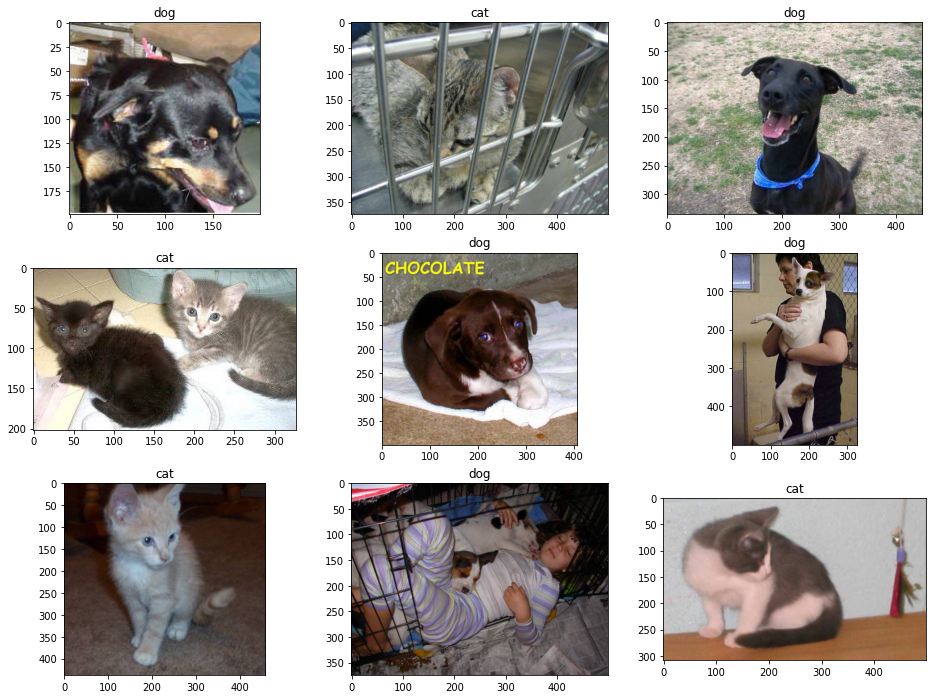

In [16]:
random_idx = np.random.randint(1, len(train_list), size=9)
fig, axes = plt.subplots(3, 3, figsize=(16, 12))

for idx, ax in enumerate(axes.ravel()): # (3,3) shape의 axes를 (9,)로 flatten
    img = Image.open(train_list[idx])
    ax.set_title(labels[idx])
    ax.imshow(img)

## **Split**

In [17]:
# startify option : train data의 class(dog, cat)분포를 유지하며 split
train_list, valid_list = train_test_split(train_list, 
                                          test_size=0.2,
                                          stratify=labels,  
                                          random_state=seed)

In [18]:
print(f"Train Data: {len(train_list)}")
print(f"Validation Data: {len(valid_list)}")
print(f"Test Data: {len(test_list)}")

Train Data: 20000
Validation Data: 5000
Test Data: 12500


## **Image Augumentation**

In [19]:
# RandomHorizonFlip : 50%확률로 좌우 반전
# RandomResizedCrop : https://pytorch.org/vision/stable/auto_examples/plot_transforms.html#sphx-glr-auto-examples-plot-transforms-py

train_transforms = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ]
)

val_transforms = transforms.Compose(
    [
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
    ]
)


test_transforms = transforms.Compose(
    [
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
    ]
)

## **Load Datasets**

In [20]:
# custom dataset 만들기

class CatsDogsDataset(Dataset):
    def __init__(self, file_list, transform=None):
        self.file_list = file_list
        self.transform = transform

    def __len__(self):
        self.filelength = len(self.file_list)
        return self.filelength

    def __getitem__(self, idx):
        img_path = self.file_list[idx]
        img = Image.open(img_path)
        img_transformed = self.transform(img)

        label = img_path.split("/")[-1].split(".")[0]
        label = 1 if label == "dog" else 0  # Binary Classification

        return img_transformed, label

In [21]:
train_data = CatsDogsDataset(train_list, transform=train_transforms)
valid_data = CatsDogsDataset(valid_list, transform=test_transforms)
test_data = CatsDogsDataset(test_list, transform=test_transforms)

In [22]:
train_loader = DataLoader(dataset = train_data, batch_size=batch_size, shuffle=True )
valid_loader = DataLoader(dataset = valid_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset = test_data, batch_size=batch_size, shuffle=True)

In [23]:
print(len(train_data), len(train_loader))
print(len(valid_data), len(valid_loader))

20000 313
5000 79


## **Efficient Attention**

### Linformer

In [24]:
efficient_transformer = Linformer(
    dim=128,
    seq_len=49+1,  # 7x7 patches + 1 cls-token
    depth=12,
    heads=8,
    k=64
)

### Visual Transformer

In [25]:
model = ViT(
    dim=128,
    image_size=224,
    patch_size=32,
    num_classes=2,
    transformer=efficient_transformer,
    channels=3,
).to(device)

## **Training**

In [26]:
# loss function
criterion = nn.CrossEntropyLoss()
# optimizer
optimizer = optim.Adam(model.parameters(), lr=lr)
# scheduler
scheduler = StepLR(optimizer, step_size=1, gamma=gamma)

In [27]:
for epoch in range(epochs):
    epoch_loss = 0
    epoch_accuracy = 0

    for data, label in tqdm(train_loader):
        data = data.to(device)
        label = label.to(device)

        output = model(data)
        loss = criterion(output, label)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        acc = (output.argmax(dim=1) == label).float().mean()
        epoch_accuracy += acc / len(train_loader)
        epoch_loss += loss / len(train_loader)

    with torch.no_grad():
        epoch_val_accuracy = 0
        epoch_val_loss = 0
        for data, label in valid_loader:
            data = data.to(device)
            label = label.to(device)

            val_output = model(data)
            val_loss = criterion(val_output, label)

            acc = (val_output.argmax(dim=1) == label).float().mean()
            epoch_val_accuracy += acc / len(valid_loader)
            epoch_val_loss += val_loss / len(valid_loader)

    print(
        f"Epoch : {epoch+1} - loss : {epoch_loss:.4f} - acc: {epoch_accuracy:.4f} - val_loss : {epoch_val_loss:.4f} - val_acc: {epoch_val_accuracy:.4f}\n"
    )

  0%|          | 0/313 [00:00<?, ?it/s]

Epoch : 1 - loss : 0.6959 - acc: 0.5080 - val_loss : 0.6904 - val_acc: 0.5496



  0%|          | 0/313 [00:00<?, ?it/s]

Epoch : 2 - loss : 0.6919 - acc: 0.5246 - val_loss : 0.6838 - val_acc: 0.5698



  0%|          | 0/313 [00:00<?, ?it/s]

Epoch : 3 - loss : 0.6844 - acc: 0.5486 - val_loss : 0.6772 - val_acc: 0.5866



  0%|          | 0/313 [00:00<?, ?it/s]

Epoch : 4 - loss : 0.6794 - acc: 0.5658 - val_loss : 0.6654 - val_acc: 0.6007



  0%|          | 0/313 [00:00<?, ?it/s]

Epoch : 5 - loss : 0.6727 - acc: 0.5767 - val_loss : 0.6634 - val_acc: 0.5967



  0%|          | 0/313 [00:00<?, ?it/s]

Epoch : 6 - loss : 0.6651 - acc: 0.5887 - val_loss : 0.6418 - val_acc: 0.6276



  0%|          | 0/313 [00:00<?, ?it/s]

Epoch : 7 - loss : 0.6552 - acc: 0.6073 - val_loss : 0.6284 - val_acc: 0.6363



  0%|          | 0/313 [00:00<?, ?it/s]

Epoch : 8 - loss : 0.6507 - acc: 0.6108 - val_loss : 0.6217 - val_acc: 0.6430



  0%|          | 0/313 [00:00<?, ?it/s]

Epoch : 9 - loss : 0.6469 - acc: 0.6124 - val_loss : 0.6160 - val_acc: 0.6537



  0%|          | 0/313 [00:00<?, ?it/s]

Epoch : 10 - loss : 0.6395 - acc: 0.6230 - val_loss : 0.6136 - val_acc: 0.6466



  0%|          | 0/313 [00:00<?, ?it/s]

Epoch : 11 - loss : 0.6323 - acc: 0.6325 - val_loss : 0.6020 - val_acc: 0.6713



  0%|          | 0/313 [00:00<?, ?it/s]

Epoch : 12 - loss : 0.6274 - acc: 0.6374 - val_loss : 0.5903 - val_acc: 0.6689



  0%|          | 0/313 [00:00<?, ?it/s]

Epoch : 13 - loss : 0.6171 - acc: 0.6499 - val_loss : 0.5857 - val_acc: 0.6869



  0%|          | 0/313 [00:00<?, ?it/s]

Epoch : 14 - loss : 0.6159 - acc: 0.6559 - val_loss : 0.5770 - val_acc: 0.6954



  0%|          | 0/313 [00:00<?, ?it/s]

Epoch : 15 - loss : 0.6125 - acc: 0.6553 - val_loss : 0.5764 - val_acc: 0.6938



  0%|          | 0/313 [00:00<?, ?it/s]

Epoch : 16 - loss : 0.6040 - acc: 0.6644 - val_loss : 0.5750 - val_acc: 0.6893



  0%|          | 0/313 [00:00<?, ?it/s]

Epoch : 17 - loss : 0.6002 - acc: 0.6716 - val_loss : 0.5815 - val_acc: 0.6911



  0%|          | 0/313 [00:00<?, ?it/s]

Epoch : 18 - loss : 0.5970 - acc: 0.6718 - val_loss : 0.5580 - val_acc: 0.7067



  0%|          | 0/313 [00:00<?, ?it/s]

Epoch : 19 - loss : 0.5945 - acc: 0.6755 - val_loss : 0.5725 - val_acc: 0.6907



  0%|          | 0/313 [00:00<?, ?it/s]

Epoch : 20 - loss : 0.5921 - acc: 0.6791 - val_loss : 0.5704 - val_acc: 0.6952

